# TP1 - Redes Neuronales II (parte 2 de 3)
## Francisco Mendizabal
## Legajo 61454

## Consignas:

### 3- Transponer la matriz documento-término, esto resultará en la matriz término-documento que provee embeddings de palabras. Explorar similaridad entre términos.

### 4- Construir la matriz término-clase con las clases disponibles en 20 Newsgroups y con estos embeddings de palabras resultantes explorar similaridad entre términos.

## Setup

In [42]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import TruncatedSVD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import make_sampling_table, skipgrams
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix
import umap.umap_ as umap
import numpy as np

In [2]:
TNG_train = fetch_20newsgroups(subset="train", remove=('headers', 'footers', 'quotes'))

In [3]:
cv1 = CountVectorizer(ngram_range=(1,2), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")
cv2 = TfidfVectorizer(ngram_range=(1,1), max_df=0.8, min_df=1e-3, max_features=None, stop_words="english")

In [26]:
# Configuro si quiero CountVectorizer o TFIDF
cv = cv1

In [46]:
TNG_cv = cv.fit_transform(TNG_train.data)
print(TNG_cv.shape)

(11314, 300)


In [6]:
#Tamaño del vocabulario
print(f'El tamaño del vocabulario es: {len(cv.get_feature_names_out())}')

El tamaño del vocabulario es: 10605


## Matriz Documento-Término

In [78]:
red = TruncatedSVD(n_components=300)
TNG_cv_red_t = red.fit_transform(TNG_cv.T)
print(TNG_cv_red_t.shape)

(10605, 300)


In [79]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")

In [80]:
neigh.fit(TNG_cv_red_t)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [96]:
# Palabra a partir de la cual se buscarán los vecinos (key)
key = cv.get_feature_names_out()[7272]
print(key)

politicians


In [97]:
idx_1 = cv.vocabulary_[key]
_, neig = neigh.kneighbors(TNG_cv_red_t[idx_1:idx_1+1])

In [98]:
# Se obtienen las palabras vecinas a la key
for n in neig[0]:
    print(cv.get_feature_names_out()[n])

politicians
shifting
fallacy
premise
conclusion
sweeping
proposition
generalization
burden
assertion
occurs
argument
valid
implies
phrases
implication
straw
invalid
false
ad


### A continuación se grafican en rojo las palabras cercanas a la key, obtenidas en el bloque anterior. Primero se utilizará TSNE, y luego UMAP.

In [99]:
X_embedded_tsne = 0
X_embedded_tsne = TSNE(n_components=2, metric="cosine").fit_transform(TNG_cv_red_t)

print(X_embedded_tsne.shape)

(10605, 2)


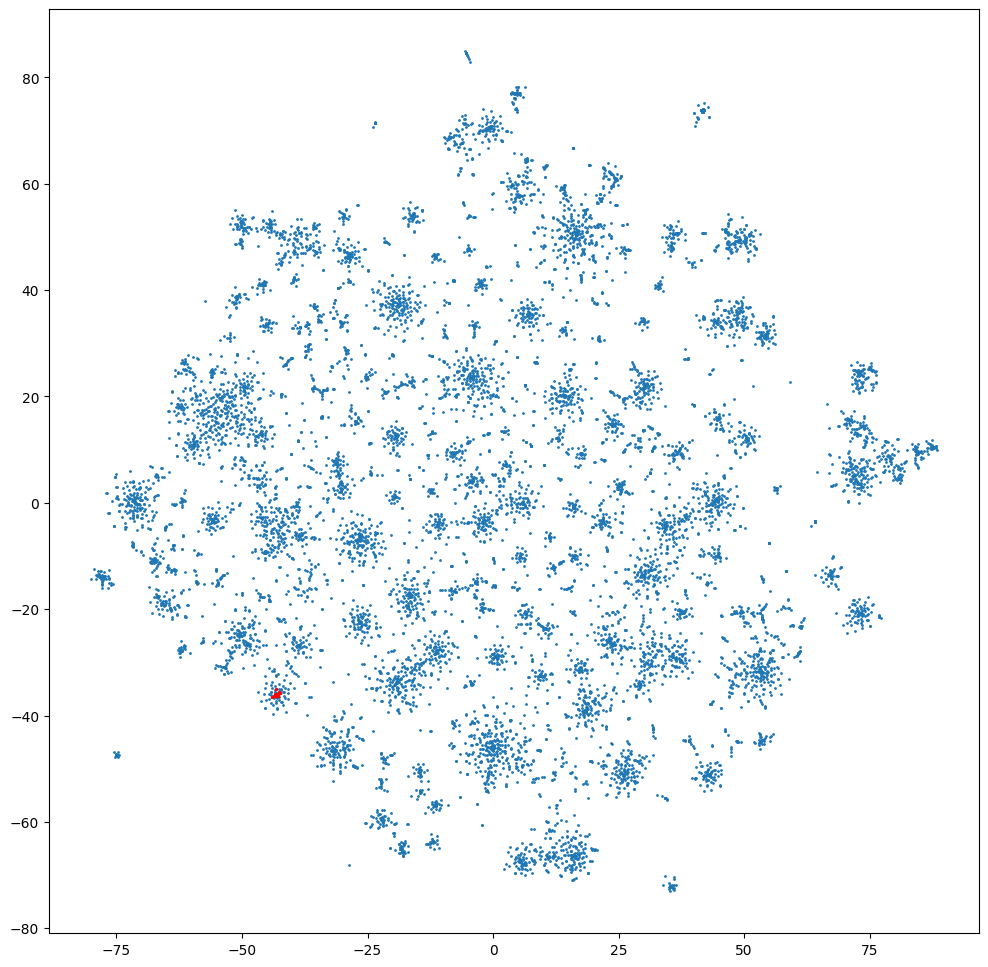

In [100]:
plt.figure(figsize=[12, 12])
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], s=1)
words=[cv.get_feature_names_out()[i] for i in neig[0]]
for word in words:
    idx = cv.vocabulary_[word]
    plt.scatter(X_embedded_tsne[idx, 0], X_embedded_tsne[idx, 1], s=2, color='red')

In [101]:
X_embedded_umap = 0
X_embedded_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(TNG_cv_red_t)
    
print(X_embedded_umap.shape)

(10605, 2)


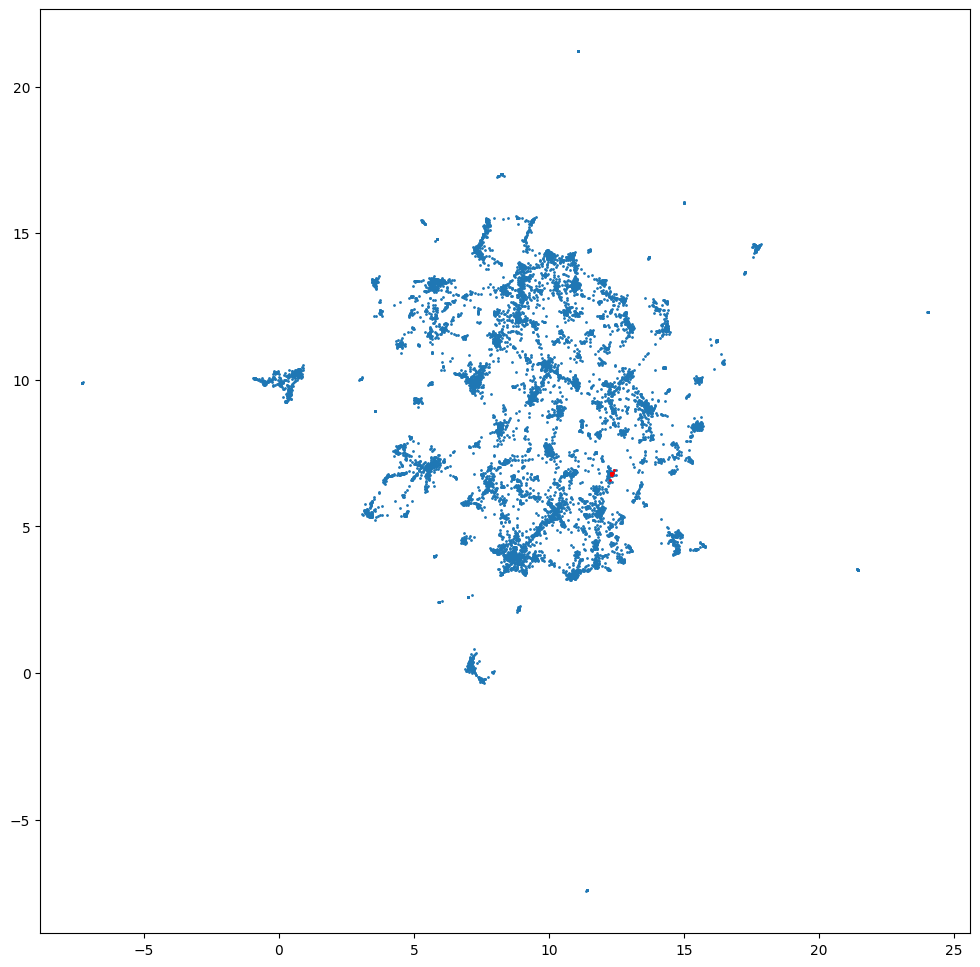

In [102]:
plt.figure(figsize=[12, 12])
plt.scatter(X_embedded_umap[:,0], X_embedded_umap[:,1], s=1)
words=[cv.get_feature_names_out()[i] for i in neig[0]]
for word in words:
    idx = cv.vocabulary_[word]
    plt.scatter(X_embedded_umap[idx, 0], X_embedded_umap[idx, 1], s=1, color='red')

### Vemos que efectivamente las palabras vecinas se ubican espacialmente cerca en los gráficos. Cabe destacar que UMAP es mucho mas rápido que TSNE, aunque tiene la desventaja de presentar algunos puntos demasiado dispersos o alejados del resto.

## Matriz Término-Clase

In [124]:
# Inicializo la matriz (clase, término)
TNG_cv_topic = np.zeros(TNG_cv[:len(TNG_train.target_names)].shape)
print(TNG_cv_topic.shape)

(20, 10605)


In [125]:
# Sumo en cada clase el vector de los documentos correspondientes
for i, topic in enumerate(TNG_train.target_names):
    for j, doc in enumerate(TNG_train.target):
        if TNG_train.target_names[TNG_train.target[j]] == topic:
            TNG_cv_topic[i] += TNG_cv[j]

In [127]:
TNG_cv_topic_t = TNG_cv_topic.T
print(TNG_cv_topic_t.shape)

(10605, 20)


In [128]:
neigh = NearestNeighbors(n_neighbors=20, metric="cosine")

In [129]:
neigh.fit(TNG_cv_topic_t)

NearestNeighbors(metric='cosine', n_neighbors=20)

In [130]:
# Palabra a partir de la cual se buscarán los vecinos (key)
key = cv.get_feature_names_out()[7272]
print(key)

politicians


In [132]:
idx_1 = cv.vocabulary_[key]
_, neig = neigh.kneighbors(TNG_cv_topic_t[idx_1:idx_1+1])

In [133]:
# Se obtienen las palabras vecinas a la key
for n in neig[0]:
    print(cv.get_feature_names_out()[n])

politicians
armed
riots
crime
crimes
talk politics
tactics
convicted
criminal
representatives
prohibited
gang
legally
governor
violent
police officer
ban
weapons
guard
deaths


### A continuación se grafican en rojo las palabras cercanas a la key, obtenidas en el bloque anterior. Primero se utilizará TSNE, y luego UMAP.

In [134]:
X_embedded_tsne = TSNE(n_components=2, metric="cosine").fit_transform(TNG_cv_topic_t)
print(X_embedded_tsne.shape)

(10605, 2)


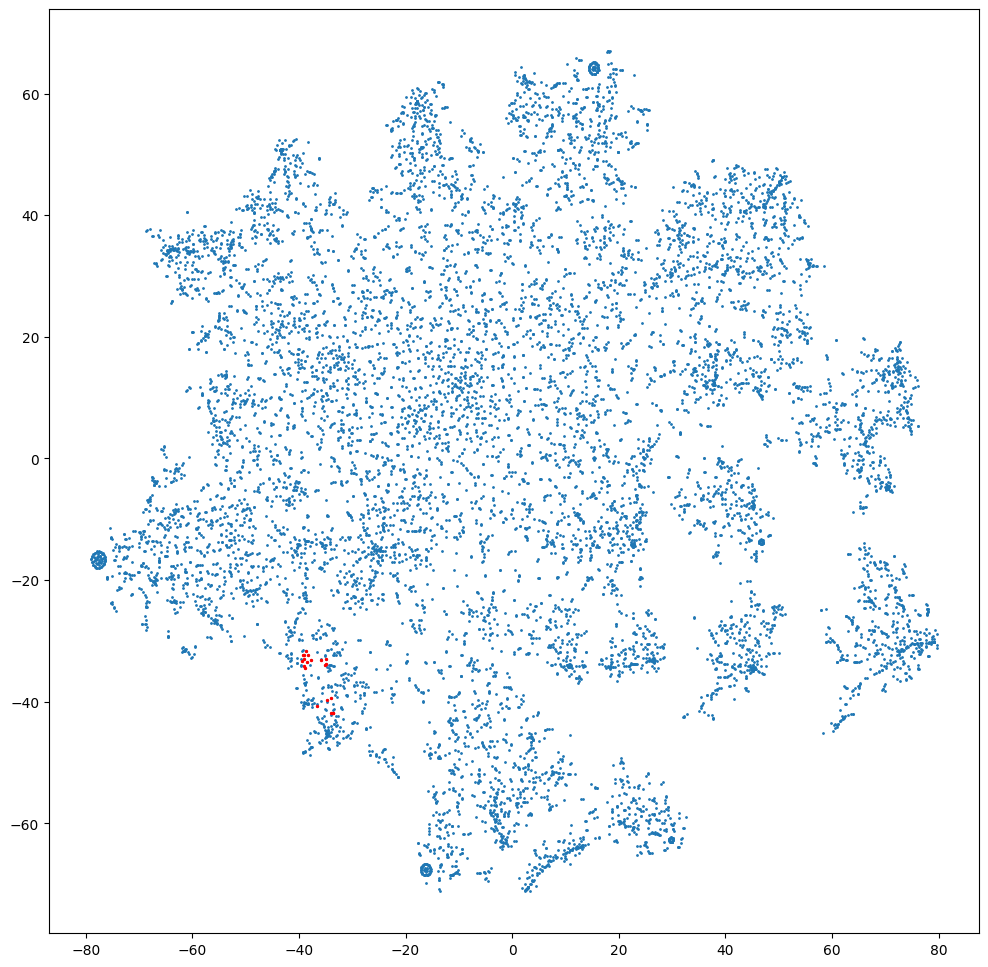

In [135]:
plt.figure(figsize=[12, 12])
plt.scatter(X_embedded_tsne[:,0], X_embedded_tsne[:,1], s=1)
words=[cv.get_feature_names_out()[i] for i in neig[0]]
for word in words:
    idx = cv.vocabulary_[word]
    plt.scatter(X_embedded_tsne[idx, 0], X_embedded_tsne[idx, 1], s=2, color='red')

In [136]:
X_embedded_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(TNG_cv_topic_t)
print(X_embedded_umap.shape)

(10605, 2)


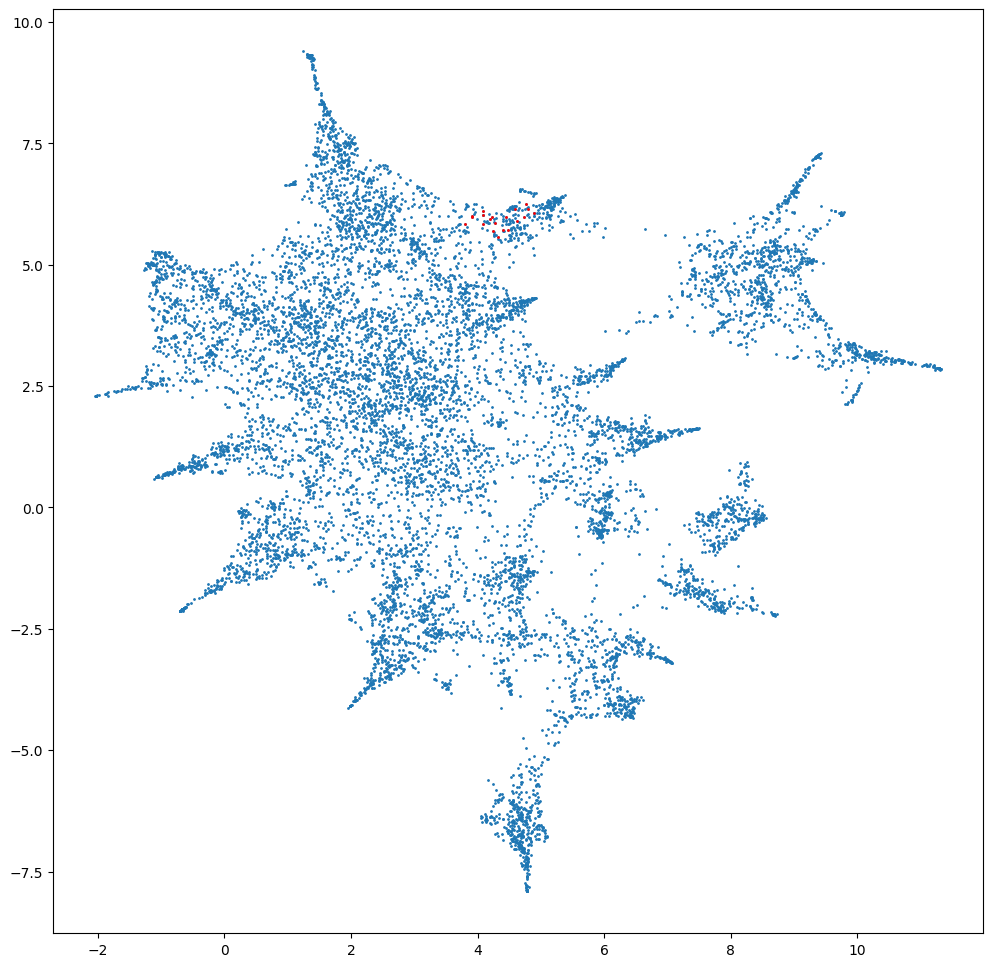

In [137]:
plt.figure(figsize=[12, 12])
plt.scatter(X_embedded_umap[:,0], X_embedded_umap[:,1], s=1)
words=[cv.get_feature_names_out()[i] for i in neig[0]]
for word in words:
    idx = cv.vocabulary_[word]
    plt.scatter(X_embedded_umap[idx, 0], X_embedded_umap[idx, 1], s=1, color='red')

### En este caso nuevamente se observa que las palabras vecinas se encuentran cerca, pero no tanto como antes. La principal diferencia es que no hay tantos grupos aislados (los cuales podrían haber ocurrido entre palabras semánticamente similares), sino que se encuentran distribuidas más uniformemente. Es posible que los gráficos puedan dividirse en 20 regiones, una para cada clase.